In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import io, signal
import pywt
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# ROOT = '/kaggle/working'

In [3]:
channels=np.array([56,60,34,9,11,13,51]) # based on the paper by Tajmirriahi et al
# [Po7,Po8,Fz,C3,Cz,C4,Pz]
channels = np.sort(channels)
channels

array([ 9, 11, 13, 34, 51, 56, 60])

In [4]:
def BCI_DATASET():
    dataset = {
        'TRAIN':{
            'A': io.loadmat('Subject_A_Train.mat'),
            'B': io.loadmat('Subject_B_Train.mat')
        },
        'TEST': {
            'A': io.loadmat('Subject_A_Test.mat'),
            'B': io.loadmat('Subject_B_Test.mat')
        }
    }
    return dataset

def get_signal(dataset,subject,test=False):
    data = {}
    if test == False:
        for i in dataset['TRAIN'][subject].keys():
            data[i] = dataset['TRAIN'][subject][i]
    
    else:
        for i in dataset['TEST'][subject].keys():
            data[i] = dataset['TEST'][subject][i]
    
    return data

def visualize_data(data):
    plt.plot(data)
    plt.show()


In [5]:
def Bandpass(input_signal,order,low,high,sampling_rate=240):
    fn = sampling_rate*0.5
    lb = low/fn
    ub = high/fn
    b,a = signal.butter(order/2,[lb,ub],'bandpass')
    output = []
    for i in range(64):
        output_signal = signal.filtfilt(b,a,input_signal[:,i])
        output.append(output_signal) 
    output = np.array(output)
    output = np.moveaxis(output,-1,1)
    return output

def Subsample(input_signal,window,sampling_rate=240):
    samples_per_window = sampling_rate*window//1000
    samples = []
    for i in range(0,7793,42):
        samples.append(input_signal[:,i:i+samples_per_window])
    
    return samples[:-6]

def Preprocess_Signals(input_data,test=False,sampling_rate=240,low=0.1,high=10,order=8,window=600):
    preprocessed_signals = []
    if test:
        for i in range(100):
            preprocessed_signals.append(Subsample(Bandpass(input_data[i],order,low,high),window))
    else:
        for i in range(85):
            preprocessed_signals.append(Subsample(Bandpass(input_data[i],order,low,high),window))
    
    return preprocessed_signals

In [6]:
dataset = BCI_DATASET()

In [7]:
subj_A_train = get_signal(dataset,'A')
Signal = subj_A_train['Signal']
Stimulus_Code = subj_A_train['StimulusCode']
Target_Char = np.array(list(subj_A_train['TargetChar'][0]))

In [8]:
subj_B_train = get_signal(dataset,'B')
Signal_B = subj_B_train['Signal']
Stimulus_Code_B = subj_B_train['StimulusCode']
Target_Char_B = np.array(list(subj_B_train['TargetChar'][0]))

In [9]:
subj_A_test = get_signal(dataset,'A',test=True)
Signal_A_test = subj_A_test['Signal']
Stimulus_Code_A_test = subj_A_test['StimulusCode']
Target_Char_A_test = np.array(list(['WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU'][0]))

In [10]:
sigs_A = Preprocess_Signals(Signal,high=20,window=667)
sign_B = Preprocess_Signals(Signal_B,high=20,window=667)
sigs_A_test = Preprocess_Signals(Signal_A_test,high=20,window=667,test=True)

In [11]:
paradigm = [['A','B','C','D','E','F'],['G','H','I','J','K','L'],['M','N','O','P','Q','R'],['S','T','U','V','W','X'],['Y','Z','1','2','3','4'],['5','6','7','8','9','_']]
paradigm

[['A', 'B', 'C', 'D', 'E', 'F'],
 ['G', 'H', 'I', 'J', 'K', 'L'],
 ['M', 'N', 'O', 'P', 'Q', 'R'],
 ['S', 'T', 'U', 'V', 'W', 'X'],
 ['Y', 'Z', '1', '2', '3', '4'],
 ['5', '6', '7', '8', '9', '_']]

In [12]:
def check_row(item,row_number):
    if item in paradigm[row_number]:
        return 1
    return 0

def is_p300(stim_code,char):
    # As each row and column was flashed for 100ms in the experiment, the number of samples = 24 (240*(100/1000))
    # We will find out the row for the corresponding stimulus code
    row = stim_code
    if stim_code > 6:
        row = stim_code-6
    return check_row(char,row-1)

def extract_flashes(Stim_Code):
    buffer = []
    flashes = []
    for i in range(0,7793,42):
        buffer.append(int(Stim_Code[i]))
    for i in range(len(buffer)):
        if buffer[i] > 0:
            flashes.append(buffer[i])
        
    return flashes

def get_labels(Stim_Code,Target_Char):
    labels = []
    sample_labels = []
    for i,char in zip(Stim_Code,Target_Char):
        flashes = extract_flashes(i)
        for j in flashes:
            sample_labels.append(is_p300(j,char))
        labels.append(sample_labels)
        sample_labels = []
    return labels

In [13]:
labels = get_labels(Stimulus_Code,Target_Char)
labels_B = get_labels(Stimulus_Code_B,Target_Char_B)
labels_A_test = get_labels(Stimulus_Code_A_test,Target_Char_A_test)

In [14]:
def extract_p300_signals(labels):
    buffer = []
    p300 = []
    buffer_2 = []
    non_p300 = []
    for char in range(85):
        for flash in range(180):
            if labels[char][flash]==1:
                buffer.append(flash)
            else:
                buffer_2.append(flash)
        non_p300.append(buffer_2)
        p300.append(buffer)
        buffer = []
        buffer_2 = []
                
    return [p300,non_p300]
def clone_signals(signals,times):
    print(np.array(signals).shape)
    cloned_signals = signals*(times+1)
    return np.array(cloned_signals)

In [15]:
subj_A = extract_p300_signals(labels)
p300_A = []
for i in range(85):
    for j in range(len(subj_A[0][i])):
        p300_A.append(sigs_A[i][j])
print(len(p300_A))
clones = clone_signals(p300_A,4)
clones.shape

2550
(2550, 64, 160)


(12750, 64, 160)

In [16]:
p300_A = np.array(p300_A)

In [17]:
p300_A.shape

(2550, 64, 160)

In [18]:
np300_A = []
for i in range(85):
    for j in range(len(subj_A[1][i])):
        np300_A.append(sigs_A[i][j])

np300_A = np.array(np300_A)
np300_A.shape

(12750, 64, 160)

In [19]:
p300_balanced = p300_A[:300]
np300_balanced = np300_A[:300]
p300_balanced = p300_balanced[:,channels]
np300_balanced = np300_balanced[:,channels]
p300_balanced = p300_balanced.reshape((10,210,160))
np300_balanced = np300_balanced.reshape((10,210,160))


In [20]:
# proof of data balancing (done as done by Tajmirriahi et al)
print(f'The size of balanced p300 signals is {p300_balanced.shape}, and non p300 signals is {np300_balanced.shape}')

The size of balanced p300 signals is (10, 210, 160), and non p300 signals is (10, 210, 160)


In [21]:
np300_A = np300_A[:2550]
np300_A.shape

(2550, 64, 160)

In [22]:
train_p300_A = p300_A[:2500]
test_p300_A = p300_A[2500:2550]
train_np300_A = np300_A[:2500]
test_np300_A = np300_A[2500:2550]


In [23]:
train_p300_A = train_p300_A.reshape((2500*64,160))
train_np300_A = train_np300_A.reshape((2500*64,160))
test_p300_A = test_p300_A.reshape((50*64,160))
test_np300_A = test_np300_A.reshape((50*64,160))

In [24]:
wavelets = pywt.wavelist(kind='continuous')

In [25]:
wavelets

['cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'mexh',
 'morl',
 'shan']

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


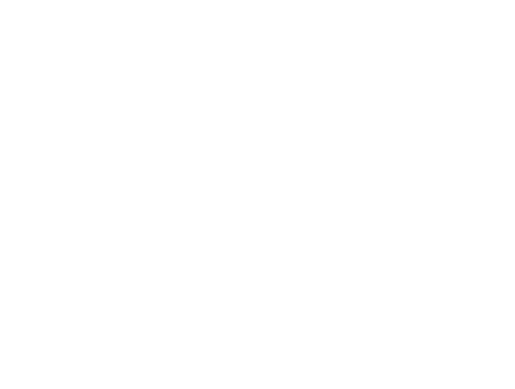

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pywt  # Ensure pywt (PyWavelets) is installed

wavelets = ['morl', 'fbsp1-1.5-1.0', 'shan1.0-1.5', 'mexh']
wavelet_names = ['morlet', 'fbsp', 'shannon', 'mexican_hat']

# Define new save path
save_path = r"C:\Users\hrush\OneDrive\Documents\Bci work\BCI-3-work"

for wavelet, name in zip(wavelets, wavelet_names):
    counter_p300 = 0
    counter_np300 = 0
    widths = np.arange(1, 100)
    time = np.linspace(0, 0.667, num=160)

    # Change directory creation to new path
    os.mkdir(os.path.join(save_path, name))
    os.mkdir(os.path.join(save_path, name, 'p300'))
    os.mkdir(os.path.join(save_path, name, 'np300'))

    for j in range(10):
        for i in p300_balanced[j]:
            cwtmatr, freqs = pywt.cwt(i, widths, wavelet)
            if name == 'shannon' or name == 'fbsp':
                plt.imsave(os.path.join(save_path, name, 'p300', str(counter_p300) + '.jpg'), np.imag(cwtmatr))
            else:
                plt.imsave(os.path.join(save_path, name, 'p300', str(counter_p300) + '.jpg'), cwtmatr)
            counter_p300 += 1

        for i in np300_balanced[j]:
            cwtmatr, freqs = pywt.cwt(i, widths, wavelet)
            if name == 'shannon' or name == 'fbsp':
                plt.imsave(os.path.join(save_path, name, 'np300', str(counter_np300) + '.jpg'), np.imag(cwtmatr))
            else:
                plt.imsave(os.path.join(save_path, name, 'np300', str(counter_np300) + '.jpg'), cwtmatr)
            plt.axis('off')
            counter_np300 += 1
        print(j)


In [28]:
len(os.listdir(r"C:\Users\hrush\OneDrive\Documents\Bci work\BCI-3-work\morlet\p300"))


2100

In [ ]:
# os.rmdir('/kaggle/working/morlet/p300')
# os.rmdir('/kaggle/working/morlet/np300')
# os.rmdir('/kaggle/working/morlet')

In [40]:
vgg16 = tf.keras.applications.VGG16(include_top=False,input_shape=(256,256,3),weights= 'imagenet')

In [ ]:
# # building the model 
# def conv_block(input_value,alpha=0.2,dropout=False,pool_size=2,stride_size=2):
#     block = tf.keras.models.Sequential(
#     [
#         tf.keras.layers.Conv2D(32,5),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.LeakyReLU(negative_slope=alpha),
#         tf.keras.layers.MaxPooling2D(pool_size,stride_size),
#     ]
#     )
#     x = block(input_value)
#     if dropout:
#         x = tf.keras.layers.Dropout(0.3)(x)
#     return tf.keras.Model(input_value,x)

# def Model(input_value):
#     block1 = conv_block(input_value)
#     x = block1(input_value)
#     block2 = conv_block(x)
#     x = block2(x)
#     block3 = conv_block(x,alpha=0,dropout=True,pool_size=4,stride_size=6)
#     x = block3(x)
#     fully_connected = tf.keras.models.Sequential(
#     [
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(64),
#         tf.keras.layers.Dense(32,'tanh'),
#         tf.keras.layers.Dense(1,'sigmoid')
#     ]
#     )
#     x = fully_connected(x)
#     return tf.keras.Model(input_value,x)
        

In [41]:
def build_vgg16():
    vgg16 = tf.keras.applications.VGG16(include_top=True,input_shape=(256,256,3),weights=None,classes=1,classifier_activation='sigmoid')
    
    return vgg16

def train_vgg(train_dataset,valid_dataset):
    vgg16 = build_vgg16()
    vgg16.compile(tf.keras.optimizers.Adadelta(0.001),loss='binary_crossentropy',metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    h1 = vgg16.fit(train_dataset,batch_size=8,epochs=50,validation_data=valid_dataset)
    return h1

In [ ]:
# def build_CNN():
#     model = Model(tf.keras.Input((256,256,3)))
#     return model

# def train_CNN(train_dataset,valid_dataset):
#     CNN = build_CNN()
#     CNN.compile(tf.keras.optimizers.Adadelta(0.001),loss='binary_crossentropy',metrics=['acc',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
#     h1 = CNN.fit(train_dataset,batch_size=8,epochs=300,validation_data=valid_dataset)
#     return h1

In [ ]:
# h = []
# base_path = r"C:\Users\hrush\OneDrive\Documents\Bci work\BCI-3-work"

# for directory in os.listdir(base_path)[1:]:
#     dir_path = os.path.join(base_path, directory)

#     train_dataset = tf.keras.utils.image_dataset_from_directory(
#         dir_path, batch_size=8, shuffle=True, validation_split=0.2, seed=42, subset='training'
#     )

#     valid_dataset = tf.keras.utils.image_dataset_from_directory(
#         dir_path, batch_size=8, shuffle=True, validation_split=0.2, seed=42, subset='validation'
#     )

#     h.append(train_vgg(train_dataset, valid_dataset))


NotFoundError: Could not find directory C:\Users\hrush\OneDrive\Documents\Bci work\BCI-3-work\.gitattributes

In [31]:
len(os.listdir(r"C:\Users\hrush\OneDrive\Documents\Bci work\BCI-3-work\mexican_hat\np300"))


2100

In [32]:
directories = []
base_path = r"C:\Users\hrush\OneDrive\Documents\Bci work\BCI-3-work"

for i in os.listdir(base_path):
    if i == '.virtual_documents':  # Skip this directory
        continue
    else:
        path = os.path.join(base_path, i)
        directories.append(path)

directories


['C:\\Users\\hrush\\OneDrive\\Documents\\Bci work\\BCI-3-work\\.git',
 'C:\\Users\\hrush\\OneDrive\\Documents\\Bci work\\BCI-3-work\\.gitattributes',
 'C:\\Users\\hrush\\OneDrive\\Documents\\Bci work\\BCI-3-work\\BCI_Comp_III_Wads_2004',
 'C:\\Users\\hrush\\OneDrive\\Documents\\Bci work\\BCI-3-work\\fbsp',
 'C:\\Users\\hrush\\OneDrive\\Documents\\Bci work\\BCI-3-work\\mexican_hat',
 'C:\\Users\\hrush\\OneDrive\\Documents\\Bci work\\BCI-3-work\\morlet',
 'C:\\Users\\hrush\\OneDrive\\Documents\\Bci work\\BCI-3-work\\shannon']

In [ ]:
# import os

# h = []
# base_path = r"C:\Users\hrush\OneDrive\Documents\Bci work\BCI-3-work"

# # Iterate over directories in the base path and filter out non-image directories
# for directory in os.listdir(base_path):
#     dir_path = os.path.join(base_path, directory)
    
#     # Check if the directory contains images (or is not hidden like .git)
#     if os.path.isdir(dir_path) and not directory.startswith('.') and any(f.endswith(('.png', '.jpg', '.jpeg', '.bmp')) for f in os.listdir(dir_path)):
        
#         # Load the datasets
#         train_dataset = tf.keras.utils.image_dataset_from_directory(
#             dir_path, 
#             batch_size=32, 
#             shuffle=True, 
#             validation_split=0.2, 
#             seed=42, 
#             subset='training'
#         )

#         valid_dataset = tf.keras.utils.image_dataset_from_directory(
#             dir_path, 
#             batch_size=32, 
#             shuffle=True, 
#             validation_split=0.2, 
#             seed=42, 
#             subset='validation'
#         )
        
#         # Add the result to the list
#         h.append(train_vgg(train_dataset, valid_dataset))


In [45]:
import tensorflow as tf

# Example directory paths where your images are stored
train_dir = 'path_to_train_directory'
valid_dir = 'path_to_valid_directory'

# Load the train and validation datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dir_path,
    image_size=(256, 256),
    batch_size=8,
    label_mode='binary',  # Use 'binary' if you have binary classification
    shuffle=True
)

valid_dataset = tf.keras.utils.image_dataset_from_directory(
    dir_path,
    image_size=(256, 256),
    batch_size=8,
    label_mode='binary',
    shuffle=True
)

# Now you can pass the datasets to the train_vgg function
h1 = train_vgg(train_dataset, valid_dataset)


Found 4200 files belonging to 2 classes.
Found 4200 files belonging to 2 classes.
Epoch 1/50
  6/525 ━━━━━━━━━━━━━━━━━━━━ 34:37 4s/step - binary_accuracy: 0.3031 - loss: 0.8137 - precision: 0.0000e+00 - recall: 0.0000e+00

KeyboardInterrupt: 